## Era5 to Daymet (1)10 --> 2.5 arcmin (2) 15 --> 3.75 arcmin

Dan:
```
Hi Kurihana, Takuya, for your current task of downscaling ERA5 (CONUS) -- > Daymet for the two variables precipitation and temperature, can you please use all the three loss (MSE, Gradient, and percentile) and evaluate the performance using a comprehensive set of metrics (RMSE, R2, Taylor diagram, PDF, or others) to help us better understand which loss works better for which variables based on which evaluation metrics? Thanks! 
```

- RMSE
    - RMSE for mean, $\sigma_1, \sigma_2, \sigma_3$
- R2
- SSIM
- Fourier diagram distance
- PDF image:0
- Scatter plot image:0
- Taylor diagram

In [1]:
import os
import copy
import pandas as pd
import glob
import numpy as np
import scipy.stats as stats
from scipy.stats import gaussian_kde
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [48]:
! pip install git+https://github.com/pySTEPS/pysteps

  Cloning https://github.com/pySTEPS/pysteps to /private/var/folders/2s/ncdc1rdj40v_2s10fz6rc5700000gp/T/pip-req-build-6qhdri7q
  Running command git clone --filter=blob:none --quiet https://github.com/pySTEPS/pysteps /private/var/folders/2s/ncdc1rdj40v_2s10fz6rc5700000gp/T/pip-req-build-6qhdri7q
  Resolved https://github.com/pySTEPS/pysteps to commit 5fd4dc84317e59452d9a9b97075caba0abfe6bd0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached jsmin-3.0.1-py3-none-any.whl
  Created wheel for pysteps: filename=pysteps-1.15.0-cp310-cp310-macosx_10_9_x86_64.whl size=838101 sha256=1749aba63dbe45fbb51505d9f4ee0301a5dcc80c6a22cf4dfd2fe8ad1dd84254
  Stored in directory: /private/var/folders/2s/ncdc1rdj40v_2s10fz6rc5700000gp/T/pip-ephem-wheel-cache-6e1i810h/wheels/af/a7/2b/735560bb673a92f6a9e1087471c59c78eef46c303fe7d96599
Successfully built pysteps


In [2]:
import xarray as xr
import xskillscore as xs

In [3]:
from pysteps.verification.spatialscores import fss as FSS

Pysteps configuration file found at: /Users/ttt/miniconda3/envs/clim/lib/python3.10/site-packages/pysteps/pystepsrc



In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LinearSegmentedColormap

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [5]:
%load_ext autoreload
%autoreload 2
from taylor import TaylorDiagram
from metrics import *

In [6]:
%load_ext autoreload
%autoreload 2
from psd import psd
from powerspectrum import ps_con_method

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
VARIABLE_NAMES= {
   # "prcp" : 'prcp',
    "total_precipitation_24hr":  "total_precipitation_24hr" 
}

In [8]:
basedir="/Users/ttt/Documents/projects/super-resolution"

Lat and Lon from (test A): 2.5arcmin, (test B): 3.75arcmin

In [9]:
def get_lat_weight(latitudes):
    # Convert latitudes to radians and compute weights
    lat_radians = np.deg2rad(latitudes)
    weights = np.cos(lat_radians).clip(0., 1.)
    print("Mean", np.mean(weights))
    return weights

In [10]:
lats = np.load("/Users/ttt/Documents/projects/super-resolution/inference_era2daymet/15arcmin-3.75arcmin/lat.npy")

In [11]:
lat_weights = get_lat_weight(lats)
lat_weights = lat_weights[..., np.newaxis]
lat_weights.shape

Mean 0.7686381343792881


(480, 1)

In [12]:
lons = np.load("/Users/ttt/Documents/projects/super-resolution/inference_era2daymet/15arcmin-3.75arcmin/lon.npy")

### Load dataset

In [13]:
basedatadir = "/Users/ttt/Documents/projects/super-resolution/inference_era2daymet/15arcmin-3.75arcmin"

In [18]:
variables = ['total_precipitation_24hr']
loss_metrics =  ['mse', 'imagegradient'] 
production='production_daymet_2020' #'test'
experiment_pairs = {
    # land & era5 tp, era5 tp, land, standard
    "imagegradient": ["3222161"], #['3222161'], #['3106983'], #['3077532'], #["3076499", "3076618", "3076620", "3076621", "3077532"],
    "mse": ['3215715'],#['3215715', '3190616', '3215780'] #['3129425'] #["3076623", "3076624", "3076625", "3076626"],
}

In [19]:
import time
thres = np.log1p(0.25); print(thres)
def get_data(truth_or_pred):
    Var = {}
    s1 = time.time()
    for var in variables:
        for l in loss_metrics:
            expnames = experiment_pairs[l]
            for expname in expnames:
                print(f"START: {var} {l} {expname} | {(time.time()-s1)/60.} [m]")
                filelist = sorted(glob.glob(
                    os.path.join(*[basedatadir, l, var, expname, production,  f"{truth_or_pred}*.npy"])))
                fname = os.path.join(*[basedatadir, l, var, expname, production, f"{truth_or_pred}*.npy"])
                  
                #assert len(filelist) > 0, f"File Not Found {fname}"
                if len(filelist) > 0:

                    data_array = None
                    for idx, ifile in enumerate(filelist):
                        data = np.load(ifile).astype(np.float32)

                        if var in {'prcp', "total_precipitation_24hr"}:
                            data[np.where(data < thres)] = 0      
                    
                        if idx > 0:
                            data_array = np.concatenate([data_array, data], axis=0, dtype=np.float32)
                        else:
                            data_array = data
            
                    Var[f'{var}-{l}-{expname}'] = data_array
    return Var

0.22314355131420976


In [17]:
# Predict data
Preds = {}
#assert Preds 
Preds = get_data('prediction')
#Preds.update(Preds2)

START: total_precipitation_24hr mse 3215715 | 1.5894571940104166e-08 [m]
START: total_precipitation_24hr imagegradient 3222161 | 0.0984200676282247 [m]
START: prcp mse 3215715 | 0.18769141832987468 [m]
START: prcp imagegradient 3222161 | 0.18771568139394124 [m]


In [21]:
Preds.keys()

dict_keys(['total_precipitation_24hr-mse-3215715', 'total_precipitation_24hr-imagegradient-3222161'])

In [22]:
Truths = {}
Truths = get_data('groundtruth')
#Truths.update(Truths2)

START: total_precipitation_24hr mse 3215715 | 1.9868214925130207e-08 [m]
START: total_precipitation_24hr imagegradient 3222161 | 0.08239409923553467 [m]


In [23]:
Preds.keys()

dict_keys(['total_precipitation_24hr-mse-3215715', 'total_precipitation_24hr-imagegradient-3222161'])

Issue Mar.7: NaN output for some reasons

In [45]:
non_nan_final_indices = {
    'prcp-mse-3129425': 365, 
    'prcp-imagegradient-3128692': 272
}

In [70]:
np.unique(np.where(np.isnan(Preds['total_precipitation_24hr-imagegradient-3222161']))[0])

array([], dtype=int64)

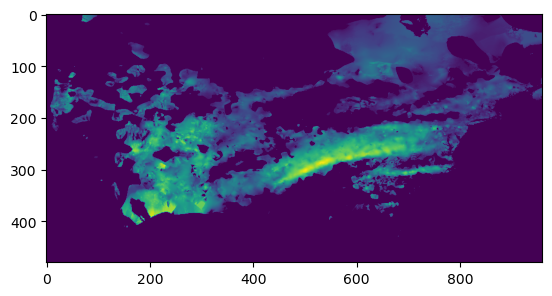

In [71]:
plt.imshow(Truths['total_precipitation_24hr-imagegradient-3222161'][-1])

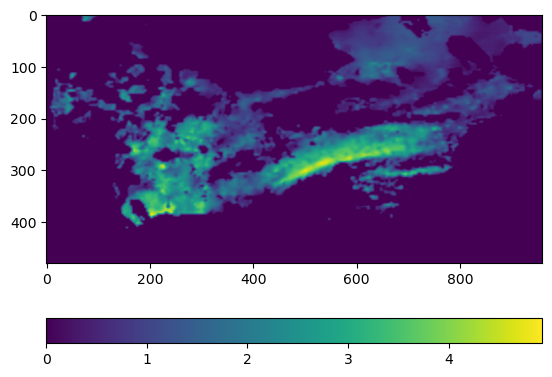

In [72]:
plt.imshow(Preds['total_precipitation_24hr-imagegradient-3222161'][-1], vmin=0)
plt.colorbar(orientation='horizontal')

#### evaluation

In [24]:
def quantile_rmse(x, y, q):
    """
        x: pred
        y: truth 
        q: 0 - 1. 1,2,3 sigma = 0.6827, 0.9545, 0.9973  
    """
    #0.6827, 0.9545, 0.9973
    index = np.where(y>=np.quantile(y, q))
    rmse =  np.sqrt(np.mean(np.square(x[index] -  y[index] )))
    return rmse

In [25]:
def normalize(float_array,vmax, vmin ):
    # Normalize the array to range [0, 1]
    norm_array = (float_array - vmin) / (vmax - vmin)

    # Scale and convert to integers in range [0, 255]
    int_array = (norm_array * 255).astype(np.uint8)
    return int_array

In [26]:
Metrics = {}
for (k, preds), (_, truths) in zip(Preds.items(),  Truths.items()):
    
    non_nan_final_index = 365 #non_nan_final_indices.get(k, 365)
    
    corrs = np.array([])
    wrmses = np.array([])
    s1rmses = np.array([])
    s2rmses = np.array([])
    s3rmses = np.array([])
    ssim_scores = np.array([])
    psnr_scores = np.array([])
    
    for it, pred, truth in zip(range(non_nan_final_index), preds, truths ):
        
        corr = clim_pearsoner(x_sim=pred, x_obs=truth )
        wrmse = lat_weight_rmse(x_sim=pred, x_obs=truth, lat_weights=lat_weights)
        corrs = np.append(corrs, corr) 
        wrmses = np.append(wrmses, wrmse)
        
        # >1, 2, 3 sigma rmses
        s1, s2, s3 = 0.6827, 0.9545, 0.9973
        s1rmse = quantile_rmse(pred, truth, s1)
        s2rmse = quantile_rmse(pred, truth, s2)
        s3rmse = quantile_rmse(pred, truth, s3)
        s1rmses = np.append(s1rmses, s1rmse)
        s2rmses = np.append(s2rmses, s2rmse)
        s3rmses = np.append(s3rmses, s3rmse)
        
        # transformation
        vmin = min(np.nanmin(pred), np.nanmin(truth))
        vmax = max(np.nanmax(pred), np.nanmax(truth))
        pred= normalize(pred, vmax=vmax, vmin=vmin)
        truth= normalize(truth, vmax=vmax, vmin=vmin)  
    
        # calc
        _ssim = ssim(pred, truth)
        _psnr = psnr(pred,truth)
        ssim_scores = np.append(ssim_scores, _ssim)
        psnr_scores = np.append(psnr_scores, _psnr)
        
    
    # Add mean
    corr_mean =  np.mean(corrs)
    wrmse_mean= np.mean(wrmses)
    ssim_mean = np.mean(ssim_scores)
    psnr_mean = np.mean(psnr_scores)
    s1rmse_mean = np.mean(s1rmses)
    s2rmse_mean = np.mean(s2rmses)
    s3rmse_mean = np.mean(s3rmses)
    
    # store at dict
    Metrics[k] = {
        'corr': corr_mean,  'rmse': wrmse_mean, 
        "rmse_sigma1": s1rmse_mean,
        "rmse_sigma2": s2rmse_mean,
        "rmse_sigma3": s3rmse_mean,
        'ssim': ssim_mean, 'psnr': psnr_mean
    }

In [27]:
Extremes = {}
for (k, preds), (_, truths) in zip(Preds.items(),  Truths.items()):
    
    non_nan_final_index = 365 #non_nan_final_indices.get(k, 365) 
    exrmses = np.array([])
   
    for it, pred, truth in zip(range(non_nan_final_index), preds, truths ):
        
        # >1, 2, 3 sigma rmses
        ex= 0.9999
        exrmse = quantile_rmse(pred, truth, ex)
        exrmses = np.append(exrmses, exrmse)
        
      
    exrmse_mean = np.mean(exrmses)
    
    # store at dict
    Extremes[k] = {
        "rmse_99.99": exrmse_mean,
    }

In [25]:
pd.DataFrame(Metrics).T

,corr,rmse,rmse_sigma1,rmse_sigma2,rmse_sigma3,ssim,psnr
prcp-mse-3076623,0.743085,0.371700,0.423095,1.255940,1.793572,0.794663,21.703853
prcp-mse-3076624,0.742453,0.372249,0.423716,1.269064,1.817346,0.811104,21.635785
prcp-mse-3076625,0.710531,0.393179,0.447466,1.375935,1.990844,0.800129,21.145000
prcp-mse-3076626,0.716954,0.389098,0.442846,1.342408,1.933611,0.807321,21.309450
prcp-imagegradient-3076499,0.754792,0.363663,0.413843,1.221131,1.736100,0.831267,21.690121
prcp-imagegradient-3076618,0.745095,0.370589,0.421922,1.268129,1.814832,0.826790,21.535298
prcp-imagegradient-3076620,0.719342,0.387542,0.441042,1.338237,1.921147,0.820633,21.170190
prcp-imagegradient-3076621,0.725921,0.382571,0.435296,1.322457,1.907513,0.824069,21.285764


In [110]:
pd.DataFrame(Metrics2).T

,corr,rmse,rmse_sigma1,rmse_sigma2,rmse_sigma3,ssim,psnr
prcp-imagegradient-3077532,0.736113,0.375886,0.427712,1.275229,1.816209,0.827545,21.447706


In [21]:
pd.DataFrame(Metrics2).T

,corr,rmse,rmse_sigma1,rmse_sigma2,rmse_sigma3,ssim,psnr
prcp-imagegradient-3106983,0.723476,0.385016,0.437851,1.300307,1.926198,0.808252,21.230571


In [47]:
pd.DataFrame(Metrics).T

,corr,rmse,rmse_sigma1,rmse_sigma2,rmse_sigma3,ssim,psnr
prcp-mse-3129425,0.698697,0.402010,0.457459,1.405237,2.046353,0.797500,20.629522
prcp-imagegradient-3128692,0.747929,0.371847,0.424140,1.174480,1.675686,0.824073,21.543212


In [ ]:
# mar/12/2025
pd.DataFrame(Metrics).T

,corr,rmse,rmse_sigma1,rmse_sigma2,rmse_sigma3,ssim,psnr
prcp-mse-3190616,0.972178,0.127004,0.144571,0.347938,0.463478,0.940488,30.704922


In [92]:
# mar/19/2025
pd.DataFrame(Metrics).T

,corr,rmse,rmse_sigma1,rmse_sigma2,rmse_sigma3,ssim,psnr
total_precipitation_24hr-mse-3215715,0.972762,0.153186,0.174444,0.366521,0.497306,0.926388,29.216230
total_precipitation_24hr-mse-3215780,0.972272,0.154362,0.175752,0.376761,0.540363,0.918854,28.575428
total_precipitation_24hr-imagegradient-3222161,0.970995,0.157928,0.179941,0.391444,0.546188,0.919276,28.604912
prcp-mse-3190616,0.972425,0.126892,0.144441,0.347021,0.463979,0.944937,30.203215


In [122]:
pd.DataFrame(Extremes).T

,rmse_99.99
total_precipitation_24hr-mse-3215715,0.649927
total_precipitation_24hr-mse-3215780,0.772904
total_precipitation_24hr-imagegradient-3222161,0.733328
prcp-mse-3190616,0.652155


2020 results

In [28]:
# mar/27/2025
pd.DataFrame(Metrics).T

,corr,rmse,rmse_sigma1,rmse_sigma2,rmse_sigma3,ssim,psnr
total_precipitation_24hr-mse-3215715,0.973982,0.151117,0.171818,0.359523,0.464911,0.926374,29.310981
total_precipitation_24hr-imagegradient-3222161,0.974058,0.151084,0.171984,0.355580,0.465059,0.923531,28.742827


In [29]:
pd.DataFrame(Extremes).T

,rmse_99.99
total_precipitation_24hr-mse-3215715,0.628781
total_precipitation_24hr-imagegradient-3222161,0.639292


#### Calculate Skil Scores

##### 1. Brier Skill Score

In [30]:
def BrierScores(Preds, Truths, mm_per_day):
    Spatials = {}
    log1p_mm_per_day = np.log1p(mm_per_day)
    print(log1p_mm_per_day)
    for (k, preds), (_, truths) in zip(Preds.items(),  Truths.items()):
        s1 = time.time()
        obs = xr.DataArray(truths,
                       coords=[('time', np.arange(365)), ('lat', lats,), ('lon', lons)])

        fcst = xr.DataArray(preds[..., None],
                       coords=[('time', np.arange(365)), ('lat', lats,), ('lon', lons), ('member', np.ones(1))])

        Spatials[k] = xs.brier_score(obs > log1p_mm_per_day, (fcst > log1p_mm_per_day).mean('member'), dim=['time','lat', 'lon'] ).values
        print(f"Done {k} {(time.time() - s1)/60.} [m]")
    return Spatials

    

In [31]:
Spatials_1mm = BrierScores(Preds, Truths, mm_per_day=1)

0.6931471805599453
Done total_precipitation_24hr-mse-3215715 0.10095173120498657 [m]
Done total_precipitation_24hr-imagegradient-3222161 0.06096495389938354 [m]


In [32]:
Spatials_5mm = BrierScores(Preds, Truths, mm_per_day=5)

1.791759469228055
Done total_precipitation_24hr-mse-3215715 0.08662261565526326 [m]
Done total_precipitation_24hr-imagegradient-3222161 0.05545756419499715 [m]


In [33]:
Spatials_10mm = BrierScores(Preds, Truths, mm_per_day=10)

2.3978952727983707
Done total_precipitation_24hr-mse-3215715 0.0572476863861084 [m]
Done total_precipitation_24hr-imagegradient-3222161 0.050995059808095294 [m]


In [34]:
Spatials_30mm = BrierScores(Preds, Truths, mm_per_day=30)

3.4339872044851463
Done total_precipitation_24hr-mse-3215715 0.05316703319549561 [m]
Done total_precipitation_24hr-imagegradient-3222161 0.0937544306119283 [m]


In [35]:
BRs = {
    '1mm': Spatials_1mm, "5mm": Spatials_5mm, 
    '10mm': Spatials_10mm, '30mm': Spatials_30mm
}
df = pd.DataFrame.from_dict(BRs, orient='index').T
df.round()

,1mm,5mm,10mm,30mm
total_precipitation_24hr-mse-3215715,0.018025500618340944,0.01310199058219178,0.008005903966894977,0.001633740011415525
total_precipitation_24hr-imagegradient-3222161,0.019255755327245053,0.013381016933028919,0.0076458987347793,0.0014355141742770168


##### Fraction skill score

In [63]:
def calc_fss(Preds, Truths, thr=1, scale=4):
    results = {}
    thr = np.log1p(thr)
    for (k, preds), (_, truths) in zip(Preds.items(),  Truths.items()):
        s1 = time.time()
        fss_mean = np.mean(list(map(lambda x: FSS(x[0], x[1], thr=thr, scale=scale), zip(preds, truths))))
        results[k] = fss_mean
        print(f"Done {k} {(time.time() - s1)/60.} [m]")
    return results

In [67]:
fss_results_1mm = calc_fss(Preds, Truths, thr=1, scale=4)

Done total_precipitation_24hr-mse-3215715 0.06363985141118368 [m]
Done total_precipitation_24hr-mse-3215780 0.06355810165405273 [m]
Done total_precipitation_24hr-imagegradient-3222161 0.06355851491292318 [m]
Done prcp-mse-3190616 0.0638259490331014 [m]


In [68]:
fss_results_1mm

{'total_precipitation_24hr-mse-3215715': 0.9830935546204008,
 'total_precipitation_24hr-mse-3215780': 0.9833176845728756,
 'total_precipitation_24hr-imagegradient-3222161': 0.9788732559172391,
 'prcp-mse-3190616': 0.9806885550823802}

In [69]:
fss_results_10mm = calc_fss(Preds, Truths, thr=10, scale=4)

Done total_precipitation_24hr-mse-3215715 0.06422848304112752 [m]
Done total_precipitation_24hr-mse-3215780 0.06373701890309652 [m]
Done total_precipitation_24hr-imagegradient-3222161 0.06399379968643189 [m]
Done prcp-mse-3190616 0.06385881503423055 [m]


In [70]:
fss_results_5mm = calc_fss(Preds, Truths, thr=5, scale=4)

Done total_precipitation_24hr-mse-3215715 0.06365949710210164 [m]
Done total_precipitation_24hr-mse-3215780 0.0638456145922343 [m]
Done total_precipitation_24hr-imagegradient-3222161 0.06463960011800131 [m]
Done prcp-mse-3190616 0.06403849522272746 [m]


In [71]:
fss_results_30mm = calc_fss(Preds, Truths, thr=30, scale=4)

/Users/ttt/miniconda3/envs/clim/lib/python3.10/site-packages/pysteps/verification/spatialscores.py:677: RuntimeWarning: invalid value encountered in scalar divide
  return 1.0 - numer / denom


Done total_precipitation_24hr-mse-3215715 0.06431733369827271 [m]
Done total_precipitation_24hr-mse-3215780 0.06422693332036336 [m]
Done total_precipitation_24hr-imagegradient-3222161 0.06414903402328491 [m]
Done prcp-mse-3190616 0.06394833326339722 [m]


In [73]:
FSSs = {
    '1mm': fss_results_1mm , "5mm": fss_results_5mm ,
    '10mm': fss_results_10mm, '30mm': fss_results_30mm 
}
dfs = pd.DataFrame.from_dict(FSSs, orient='index').T
dfs

,1mm,5mm,10mm,30mm
total_precipitation_24hr-mse-3215715,0.983094,0.973391,0.962010,NaN
total_precipitation_24hr-mse-3215780,0.983318,0.971996,0.961660,NaN
total_precipitation_24hr-imagegradient-3222161,0.978873,0.967305,0.955160,NaN
prcp-mse-3190616,0.980689,0.967536,0.958501,NaN


##### Calculate PSD

In [52]:
Truths.keys()

dict_keys(['total_precipitation_24hr-mse-3215715', 'total_precipitation_24hr-imagegradient-3222161'])

In [90]:
nsamples = 100 #NOTE: max 365

Compare test A

In [ ]:
np.sqrt(np.mean(np.square(10*np.log(psd(Truths['prcp-mse'][:nsamples])[0].mean() / 
                                    psd(Preds['prcp-mse'][:nsamples])[0].mean()))) )

In [ ]:
np.sqrt(np.mean(np.square(10*np.log(psd(Truths['prcp-imagegradient'][:nsamples])[0].mean() /
                                    psd(Preds['prcp-imagegradient'][:nsamples])[0].mean()))) )

In [ ]:
pd.DataFrame({"RALSD:100sample": {'prcp-mse': 1.5752457134582745, 
                        'prcp-imagegradient': 1.8718043326129545}})

Compare test B

In [57]:
def calc_RALSD(truths, preds, nsamples=-1):
    return np.sqrt(np.mean(np.square(10*np.log(psd(truths[:nsamples])[0].mean() / 
                                    psd(preds[:nsamples])[0].mean()))) )

In [58]:
def calc_RALSD2(truths, preds, nsamples=-1):
    return np.sqrt(np.mean(np.square(10*np.log(psd(truths[:nsamples])[0] / 
                                    psd(preds[:nsamples])[0]))) )

In [31]:
RALSDs = {}
for (k, truths), (_, preds) in zip(Truths.items(), Preds.items()):
    s1 = time.time()
    RALSDs[k] = calc_RALSD(truths, preds, nsamples=nsamples)
    print(f"DONE {k} {(time.time() - s1)/60.0 } [min]")

480 960
480 960
DONE prcp-mse-3076623 1.7510657469431559 [min]
480 960
480 960
DONE prcp-mse-3076624 1.7509650150934855 [min]
480 960
480 960
DONE prcp-mse-3076625 1.7534308473269145 [min]
480 960
480 960
DONE prcp-mse-3076626 1.7555830200513205 [min]
480 960
480 960
DONE prcp-imagegradient-3076499 1.7469292362531026 [min]
480 960
480 960
DONE prcp-imagegradient-3076618 1.7586032668749492 [min]
480 960
480 960
DONE prcp-imagegradient-3076620 1.7288247187932333 [min]
480 960
480 960
DONE prcp-imagegradient-3076621 1.729631519317627 [min]


In [33]:
RALSDs

{'prcp-mse-3076623': 2.149253102516931,
 'prcp-mse-3076624': 2.4105339592161728,
 'prcp-mse-3076625': 2.775688317202236,
 'prcp-mse-3076626': 2.2935828218832177,
 'prcp-imagegradient-3076499': 1.7192473688033134,
 'prcp-imagegradient-3076618': 2.2856466026610485,
 'prcp-imagegradient-3076620': 2.272052125935933,
 'prcp-imagegradient-3076621': 2.1447059722764976}

In [30]:
ARALSDs = {}
for (k, truths), (_, preds) in zip(Truths.items(), Preds.items()):
    s1 = time.time()
    ARALSDs[k] = calc_RALSD(truths, preds, nsamples=-1)
    print(f"DONE {k} {(time.time() - s1)/60.0 } [min]")

480 960
480 960
DONE prcp-mse-3190616 6.446971269448598 [min]


In [92]:
ARALSDs

{'prcp-mse-3076623': 3.197083563663784,
 'prcp-mse-3076624': 3.366918904276032,
 'prcp-mse-3076625': 4.251671527592251,
 'prcp-mse-3076626': 3.7998754932816583,
 'prcp-imagegradient-3076499': 2.876269978424454,
 'prcp-imagegradient-3076618': 3.3565422049602973,
 'prcp-imagegradient-3076620': 3.8435518951404357,
 'prcp-imagegradient-3076621': 3.752008601131564}

In [31]:
ARALSDs # mar14 2025

{'prcp-mse-3190616': 0.06778327173048929}

In [96]:
[ f'{i:.4f}' for i in ARALSDs.values() ]

['3.1971',
 '3.3669',
 '4.2517',
 '3.7999',
 '2.8763',
 '3.3565',
 '3.8436',
 '3.7520']

fine-tune results

In [55]:
Truths.keys()

dict_keys(['total_precipitation_24hr-mse-3215715', 'total_precipitation_24hr-imagegradient-3222161'])

In [59]:
BRALSDs = {}
for (k, truths), (_, preds) in zip(Truths.items(), Preds.items()):
    #if "3215715" in k:
    #if "total_precipitation_24hr" in k:
        s1 = time.time()
        BRALSDs[k] = calc_RALSD(truths, preds, nsamples=-1)
        print(f"DONE {k} {(time.time() - s1)/60.0 } [min]")

480 960
480 960
DONE total_precipitation_24hr-mse-3215715 6.769804020722707 [min]
480 960
480 960
DONE total_precipitation_24hr-imagegradient-3222161 6.74986621538798 [min]


In [60]:
BRALSDs

{'total_precipitation_24hr-mse-3215715': 0.013492328525588687,
 'total_precipitation_24hr-imagegradient-3222161': 0.3258322773483518}

In [147]:
BRALSDs2= {}
for (k, truths), (_, preds) in zip(Truths.items(), Preds.items()):
    #if "3215715" in k:
    #if "total_precipitation_24hr" in k:
        s1 = time.time()
        BRALSDs2[k] = calc_RALSD2(truths, preds, nsamples=-1)
        print(f"DONE {k} {(time.time() - s1)/60.0 } [min]")
print(BRALSDs2)

480 960
480 960
DONE total_precipitation_24hr-mse-3215715 6.454814747969309 [min]
480 960
480 960
DONE total_precipitation_24hr-mse-3215780 6.546750104427337 [min]
480 960
480 960
DONE total_precipitation_24hr-imagegradient-3222161 6.5340965509414675 [min]
480 960
480 960
DONE prcp-mse-3190616 6.407362000147502 [min]
{'total_precipitation_24hr-mse-3215715': 20.76222210728745, 'total_precipitation_24hr-mse-3215780': 19.696687683458396, 'total_precipitation_24hr-imagegradient-3222161': 23.08281601157761, 'prcp-mse-3190616': 23.425139970708376}


#### Calculate Power spectrum

In [36]:
def exec_powspec(images):
    results = []
    for img in images:
        r = ps_con_method(img)
        results.append(r)
    return np.median(np.asarray(results),axis=0)

In [37]:
Preds.keys()

dict_keys(['total_precipitation_24hr-mse-3215715', 'total_precipitation_24hr-imagegradient-3222161'])

In [39]:
# turth
PSs = {}
PSs['truth'] = exec_powspec(Truths['total_precipitation_24hr-mse-3215715'])

for k in Preds.keys():
    PSs[k] = exec_powspec(Preds[k])

In [40]:
PSs['truth'].shape

(2, 537)

/var/folders/2s/ncdc1rdj40v_2s10fz6rc5700000gp/T/ipykernel_4287/3108727702.py:17: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(-1,None)


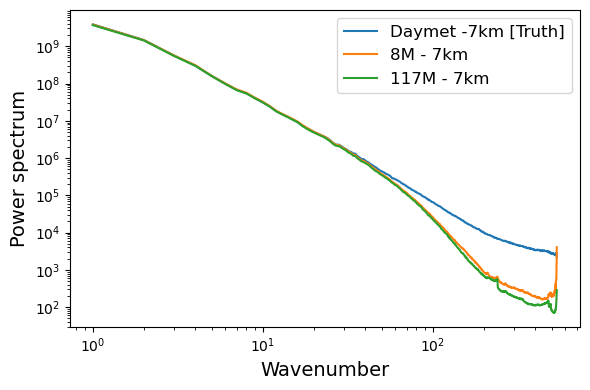

In [111]:
# MEAN
fs=12
fss=14
plt.figure(figsize=(6,4))
lnames = {
    'truth': 'Daymet -7km [Truth]',
    'total_precipitation_24hr-mse-3215715': '8M - 7km', 
    'total_precipitation_24hr-imagegradient-3222161': '117M - 7km'
}

for k, v in PSs.items():
    kvals, Abins = v
    plt.loglog(kvals[1:], Abins[1:], label=lnames[k])
plt.legend(fontsize=fs)
plt.xlabel("Wavenumber", fontsize=fss)
plt.ylabel("Power spectrum", fontsize=fss)
plt.xlim(-1,None)


plt.tight_layout()
plt.show()

/var/folders/2s/ncdc1rdj40v_2s10fz6rc5700000gp/T/ipykernel_4287/3625298335.py:18: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(-1,None)


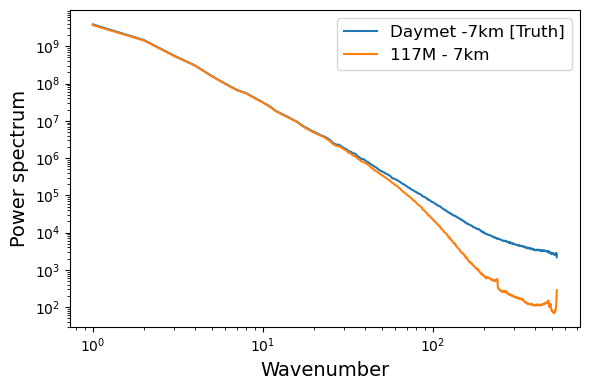

In [113]:
# MEAN
fs=12
fss=14
plt.figure(figsize=(6,4))
lnames = {
    'truth': 'Daymet -7km [Truth]',
    #'total_precipitation_24hr-mse-3215715': '8M - 7km', 
    'total_precipitation_24hr-imagegradient-3222161': '117M - 7km'
}

for k, v in PSs.items():
    kvals, Abins = v
    if k in list(lnames.keys()):
        plt.loglog(kvals[1:], Abins[1:], label=lnames[k])
plt.legend(fontsize=fs)
plt.xlabel("Wavenumber", fontsize=fss)
plt.ylabel("Power spectrum", fontsize=fss)
plt.xlim(-1,None)


plt.tight_layout()
plt.show()

In [107]:
# log(1+x) = C
# c = 0.63
np.exp(0.63) - 1

0.8776105792643432

In [109]:
np.log1p(0.87), 0.97**2

(0.6259384308664953, 0.9409)

/var/folders/2s/ncdc1rdj40v_2s10fz6rc5700000gp/T/ipykernel_19154/2287398645.py:15: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(-1,None)


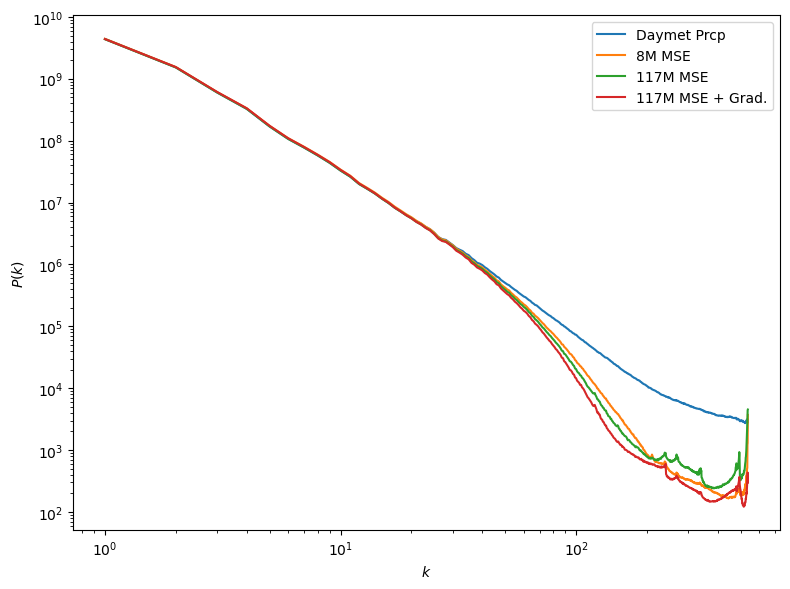

In [ ]:
# MEAN
plt.figure(figsize=(8,6))
lnames = {
    'truth': 'Daymet Prcp',
    'total_precipitation_24hr-mse-3215715': '8M MSE', 
    'total_precipitation_24hr-mse-3215780': '117M MSE', 
    'total_precipitation_24hr-imagegradient-3222161': '117M MSE + Grad.'
}

for k, v in PSs.items():
    kvals, Abins = v
    plt.loglog(kvals[1:], Abins[1:], label=lnames[k])
plt.legend()
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.xlim(-1,None)


plt.tight_layout()
plt.show()

/var/folders/2s/ncdc1rdj40v_2s10fz6rc5700000gp/T/ipykernel_19154/1222969952.py:16: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(-1,None)


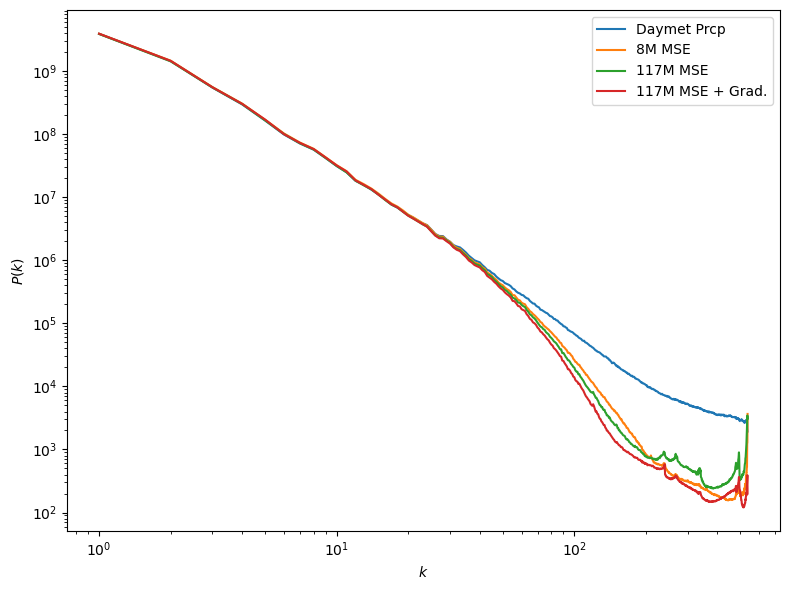

In [113]:
# MEDIAN
plt.figure(figsize=(8,6))
lnames = {
    'truth': 'Daymet Prcp',
    'total_precipitation_24hr-mse-3215715': '8M MSE', 
    'total_precipitation_24hr-mse-3215780': '117M MSE', 
    'total_precipitation_24hr-imagegradient-3222161': '117M MSE + Grad.'
}

for k, v in PSs.items():
    kvals, Abins = v
    plt.loglog(kvals[1:], Abins[1:], label=lnames[k])
plt.legend()
plt.xlabel("$k$")
plt.ylabel("$P(k)$")
plt.xlim(-1,None)
#plt.ylim(10e7, 10e8)


plt.tight_layout()
plt.show()

truth 0.0
total_precipitation_24hr-mse-3215715 79985119.99284233
total_precipitation_24hr-mse-3215780 55425472.698598355
total_precipitation_24hr-imagegradient-3222161 67493836.98915742


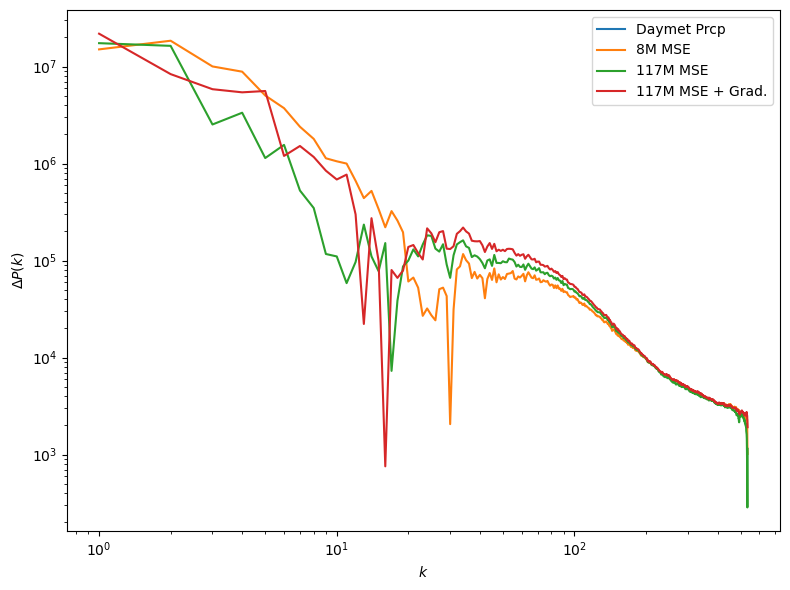

In [144]:
# MEDIAN
plt.figure(figsize=(8,6))
lnames = {
    'truth': 'Daymet Prcp',
    'total_precipitation_24hr-mse-3215715': '8M MSE', 
    'total_precipitation_24hr-mse-3215780': '117M MSE', 
    'total_precipitation_24hr-imagegradient-3222161': '117M MSE + Grad.'
}

ik=-1
for k, v in PSs.items():
    kvals, Abins = v
    plt.loglog(kvals[1:ik], np.abs(Abins[1:ik]-PSs['truth'][1][1:ik]), label=lnames[k])
    print(k, np.sum(np.abs(Abins[1:ik]-PSs['truth'][1][1:ik])))
plt.legend()
plt.xlabel("$k$")
plt.ylabel("$\Delta P(k)$")
#plt.xlim(-1,None)
#plt.ylim(10e7, 10e8)


plt.tight_layout()
plt.show()

-------------------------
#### Visualize images at index 0
- original (non-transformed image) and histogram
- groud truth and histogram
- pred and histogram

In [ ]:
nonscaled_data = np.load("/Users/ttt/Documents/projects/super-resolution/inference_era2daymet/prcp_daymet_2.5arcmin_img0.npy")

##### Non-scaled data vs other dataset

In [ ]:
nonscaled_data.shape

In [ ]:
ncols=2
nrows=1
fts=16
cbar_tick_size=12
cbar_xlabel=12
lons[lons>180] -= 360
lonmin, lonmax = np.min(lons), np.max(lons)
latmin, latmax = np.min(lats), np.max(lats)

fig, axes = plt.subplots(nrows,ncols,figsize=(9.5, 4*nrows),
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})
axes = axes.flatten()

# Define extracted colors (normalized RGB values)
colors = [
    (1.0, 1.0, 1.0), (0.7, 0.8, 0.75), (0.6, 0.75, 0.7),
    (0.5, 0.7, 0.65), (0.3, 0.8, 0.8), (0.5, 0.6, 0.9), (0.75, 0.5, 0.95),
    (0.85, 0.3, 0.85), (0.6, 0.1, 0.4), (0.2, 0.0, 0.2)
]

# Create custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_precipitation", colors)

for ax , tname, V, cbar_title_name in zip(
        axes, ['Original', 'Log-Transformed'],
        [nonscaled_data[::-1], Truths['prcp-mse'][0]],
        ['mm/day', r'$log_e(mm/day+1)$']
    ):
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
    im = ax.imshow(V, cmap = custom_cmap, transform=ccrs.PlateCarree(), 
              extent=[lonmin, lonmax, latmin, latmax], vmin=0,
              )
    ax.set_title(tname, fontsize=fts)
    ax.coastlines()  #Currently can be one of “110m”, “50m”, and “10m”.
    
    # grid format
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                        draw_labels=True,)
    gl.xlines = False
    gl.ylines = False
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', shrink=.75)
    cbar.ax.set_xlabel(cbar_title_name, fontsize=cbar_xlabel)
    cbar.ax.tick_params(labelsize=cbar_tick_size)

figdir="./figs"
os.makedirs(figdir, exist_ok=True)
plt.savefig("./prcp_truth_example_img0_2022.png", dpi=140)
plt.show()


In [ ]:
nrows=1
ncols=2

fig, axes = plt.subplots(nrows,ncols,figsize=(9.5, 4*nrows))
axes = axes.flatten()
for icolor, (ax , tname, V, cbar_title_name) in enumerate(zip(
        axes, ['Original', 'Log-Transformed'],
        [nonscaled_data[::-1], Truths['prcp-mse'][0]],
        ['mm/day', r'$log_e(x+1)$'])
    ):
    
    # Create the KDE plot (PDF)
    w = np.ones_like(V.ravel())/len(V.ravel())
    #sns.kdeplot(V.ravel(), fill=True, color=f"C{icolor}", alpha=0.35, ax=ax,)
    ax.hist(V.ravel(), bins=20, fill=True, color=f"C{icolor}",
            weights=w)

    # Add labels and title
    #ax.set_xlabel("")
    if icolor % ncols == 0:
        ax.set_ylabel("Density")
    ax.set_title(tname)
    #ax.legend(loc='upper left')
    #ax.set_xlim(1, 1.5)
    
figdir="./figs"
os.makedirs(figdir, exist_ok=True)
plt.savefig("./prcp_truth_hist_img0_202.png", dpi=140)
plt.show()

#### Peformance comparison

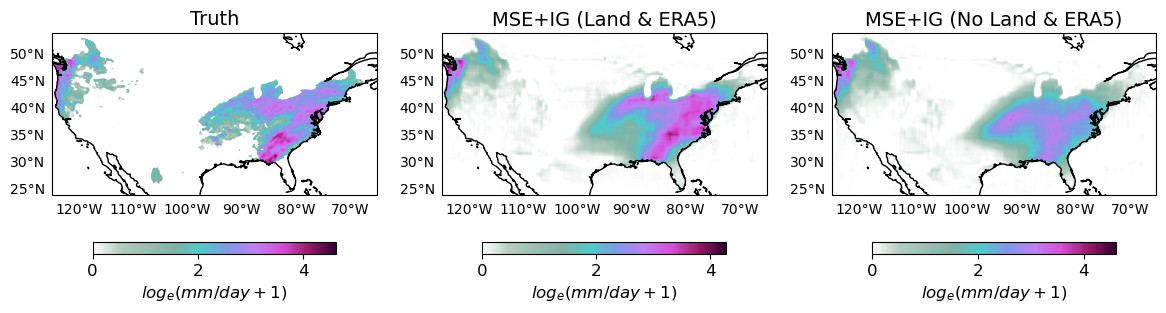

In [ ]:
ncols=3
nrows=1
fts=14
cbar_tick_size=12
cbar_xlabel=12
lons[lons>180] -= 360
lonmin, lonmax = np.min(lons), np.max(lons)
latmin, latmax = np.min(lats), np.max(lats)

fig, axes = plt.subplots(nrows,ncols,figsize=(9.5*3/2, 4*nrows),
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})
axes = axes.flatten()

# Define extracted colors (normalized RGB values)
colors = [
    (1.0, 1.0, 1.0), (0.7, 0.8, 0.75), (0.6, 0.75, 0.7),
    (0.5, 0.7, 0.65), (0.3, 0.8, 0.8), (0.5, 0.6, 0.9), (0.75, 0.5, 0.95),
    (0.85, 0.3, 0.85), (0.6, 0.1, 0.4), (0.2, 0.0, 0.2)
]

# Create custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_precipitation", colors)

for ax , tname, V, cbar_title_name in zip(
        axes, ['Truth', 'MSE+IG (Land & ERA5)', 'MSE+IG (No Land & ERA5)'],
        [Truths['prcp-mse-3076623'][0], 
         Preds['prcp-imagegradient-3076499'][0],
         Preds['prcp-imagegradient-3076621'][0] ],
        [r'$log_e(mm/day+1)$', r'$log_e(mm/day+1)$', r'$log_e(mm/day+1)$']
    ):
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
    im = ax.imshow(V, cmap = custom_cmap, transform=ccrs.PlateCarree(), 
              extent=[lonmin, lonmax, latmin, latmax], vmin=0,
              )
    ax.set_title(tname, fontsize=fts)
    ax.coastlines()  #Currently can be one of “110m”, “50m”, and “10m”.
    
    # grid format
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                        draw_labels=True,)
    gl.xlines = False
    gl.ylines = False
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', shrink=.75)
    cbar.ax.set_xlabel(cbar_title_name, fontsize=cbar_xlabel)
    cbar.ax.tick_params(labelsize=cbar_tick_size)

figdir="./figs"
os.makedirs(figdir, exist_ok=True)
plt.savefig("./prcp_truth-predict_img0_2021_mse_ig-img_15-3.75arcmin.png", dpi=140)
plt.show()

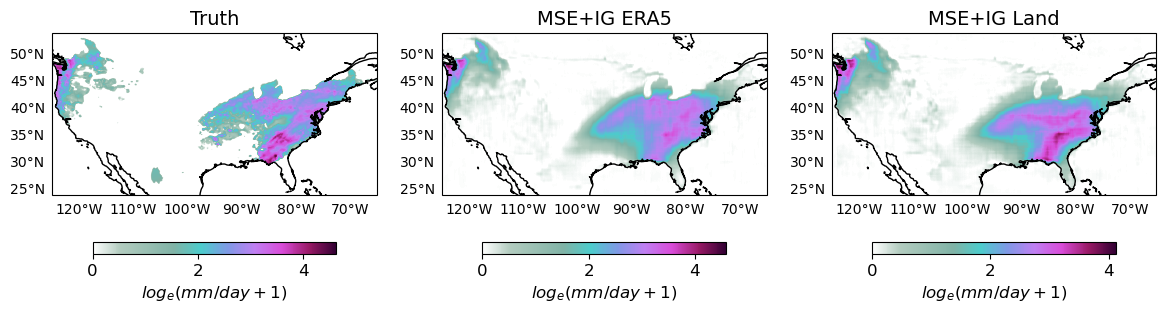

In [39]:
ncols=3
nrows=1
fts=14
cbar_tick_size=12
cbar_xlabel=12
lons[lons>180] -= 360
lonmin, lonmax = np.min(lons), np.max(lons)
latmin, latmax = np.min(lats), np.max(lats)

fig, axes = plt.subplots(nrows,ncols,figsize=(9.5*3/2, 4*nrows),
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})
axes = axes.flatten()

# Define extracted colors (normalized RGB values)
colors = [
    (1.0, 1.0, 1.0), (0.7, 0.8, 0.75), (0.6, 0.75, 0.7),
    (0.5, 0.7, 0.65), (0.3, 0.8, 0.8), (0.5, 0.6, 0.9), (0.75, 0.5, 0.95),
    (0.85, 0.3, 0.85), (0.6, 0.1, 0.4), (0.2, 0.0, 0.2)
]

# Create custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_precipitation", colors)

for ax , tname, V, cbar_title_name in zip(
        axes, ['Truth', 'MSE+IG ERA5', 'MSE+IG Land'],
        [Truths['prcp-mse-3076623'][0], 
         Preds['prcp-imagegradient-3076618'][0],
         Preds['prcp-imagegradient-3076620'][0] ],
        [r'$log_e(mm/day+1)$', r'$log_e(mm/day+1)$', r'$log_e(mm/day+1)$']
    ):
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
    im = ax.imshow(V, cmap = custom_cmap, transform=ccrs.PlateCarree(), 
              extent=[lonmin, lonmax, latmin, latmax], vmin=0,
              )
    ax.set_title(tname, fontsize=fts)
    ax.coastlines()  #Currently can be one of “110m”, “50m”, and “10m”.
    
    # grid format
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                        draw_labels=True,)
    gl.xlines = False
    gl.ylines = False
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', shrink=.75)
    cbar.ax.set_xlabel(cbar_title_name, fontsize=cbar_xlabel)
    cbar.ax.tick_params(labelsize=cbar_tick_size)

figdir="./figs"
os.makedirs(figdir, exist_ok=True)
plt.savefig("./prcp_truth-predict_img0_2021_mse_ig-img_15-3.75arcmin_land-or-era5TP.png", dpi=140)
plt.show()

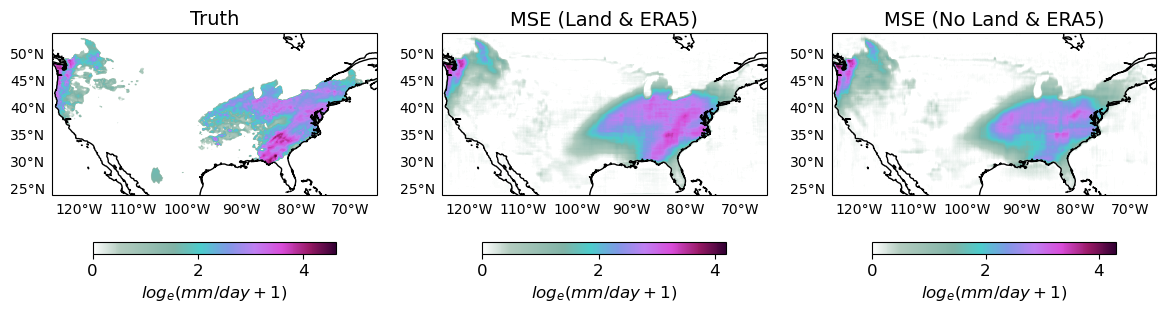

In [ ]:
ncols=3
nrows=1
fts=14
cbar_tick_size=12
cbar_xlabel=12
lons[lons>180] -= 360
lonmin, lonmax = np.min(lons), np.max(lons)
latmin, latmax = np.min(lats), np.max(lats)

fig, axes = plt.subplots(nrows,ncols,figsize=(9.5*3/2, 4*nrows),
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})
axes = axes.flatten()

# Define extracted colors (normalized RGB values)
colors = [
    (1.0, 1.0, 1.0), (0.7, 0.8, 0.75), (0.6, 0.75, 0.7),
    (0.5, 0.7, 0.65), (0.3, 0.8, 0.8), (0.5, 0.6, 0.9), (0.75, 0.5, 0.95),
    (0.85, 0.3, 0.85), (0.6, 0.1, 0.4), (0.2, 0.0, 0.2)
]

# Create custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_precipitation", colors)

for ax , tname, V, cbar_title_name in zip(
        axes, ['Truth', 'MSE (Land & ERA5)', 'MSE+IG (No Land & ERA5)'],
        [Truths['prcp-mse-3076623'][0], 
         Preds['prcp-imagegradient-3076499'][0],
         Preds['prcp-imagegradient-3076621'][0] ],
        [r'$log_e(mm/day+1)$', r'$log_e(mm/day+1)$', r'$log_e(mm/day+1)$']
    ):
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
    im = ax.imshow(V, cmap = custom_cmap, transform=ccrs.PlateCarree(), 
              extent=[lonmin, lonmax, latmin, latmax], vmin=0,
              )
    ax.set_title(tname, fontsize=fts)
    ax.coastlines()  #Currently can be one of “110m”, “50m”, and “10m”.
    
    # grid format
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                        draw_labels=True,)
    gl.xlines = False
    gl.ylines = False
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', shrink=.75)
    cbar.ax.set_xlabel(cbar_title_name, fontsize=cbar_xlabel)
    cbar.ax.tick_params(labelsize=cbar_tick_size)

figdir="./figs"
os.makedirs(figdir, exist_ok=True)
plt.savefig("./prcp_truth-predict_img0_2021_onlymse-img_15-3.75arcmin.png", dpi=140)
plt.show()

#### Fine-tune results

In [49]:
Truths.keys()

dict_keys(['total_precipitation_24hr-mse-3215715', 'total_precipitation_24hr-imagegradient-3222161'])

In [69]:
era5_28km = np.load("/Users/ttt/Documents/projects/super-resolution/production_Mar26/era5_maskxtp.npy")

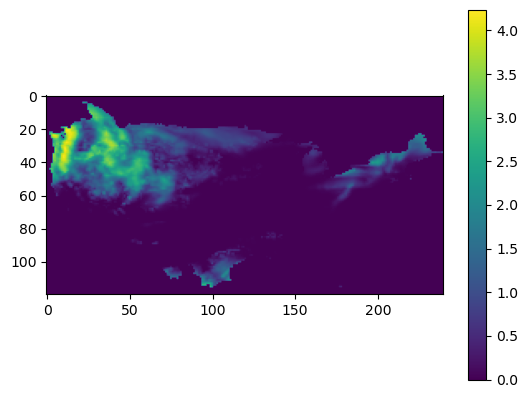

In [70]:
plt.imshow(era5_28km[0, ::-1])
plt.colorbar()

2020 images

/var/folders/2s/ncdc1rdj40v_2s10fz6rc5700000gp/T/ipykernel_4287/1005747501.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


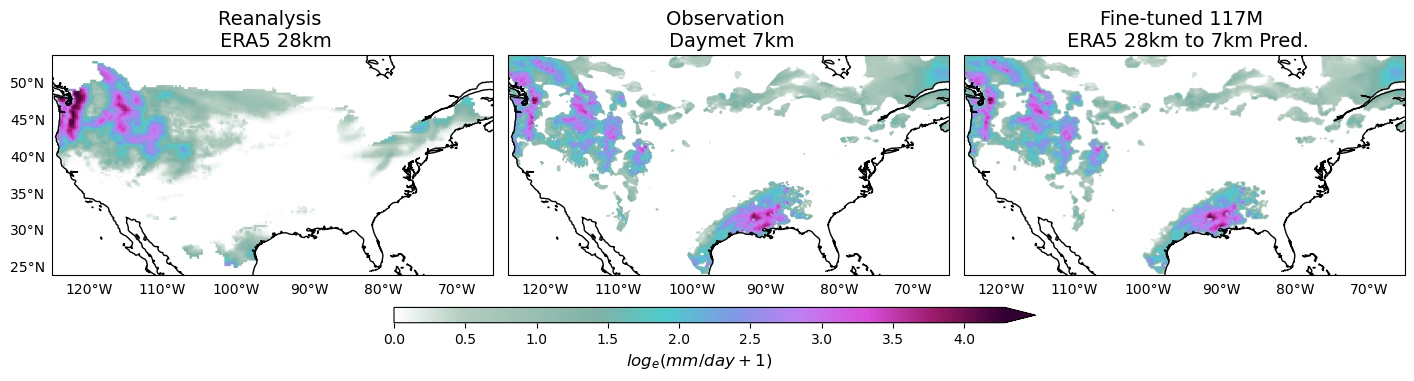

In [114]:
ncols=3
nrows=1
fts=14
cbar_tick_size=12
cbar_xlabel=12
lons[lons>180] -= 360
lonmin, lonmax = np.min(lons), np.max(lons)
latmin, latmax = np.min(lats), np.max(lats)

fig, axes = plt.subplots(nrows,ncols,figsize=(9.5*3/2, 4.5*nrows),
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})
axes = axes.flatten()

# Define extracted colors (normalized RGB values)
colors = [
    (1.0, 1.0, 1.0), (0.7, 0.8, 0.75), (0.6, 0.75, 0.7),
    (0.5, 0.7, 0.65), (0.3, 0.8, 0.8), (0.5, 0.6, 0.9), (0.75, 0.5, 0.95),
    (0.85, 0.3, 0.85), (0.6, 0.1, 0.4), (0.2, 0.0, 0.2)
]

# Create custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_precipitation", colors)

for ax , tname, V, cbar_title_name in zip(
        axes, ['Reanalysis \n ERA5 28km', 'Observation \n Daymet 7km', 'Fine-tuned 117M \n ERA5 28km to 7km Pred.'],
        [era5_28km[0, ::-1],
         Truths['total_precipitation_24hr-imagegradient-3222161'][0], 
         Preds['total_precipitation_24hr-imagegradient-3222161'][0], ],
        [r'$log_e(mm/day+1)$', r'$log_e(mm/day+1)$', r'$log_e(mm/day+1)$']
    ):
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
    im = ax.imshow(V, cmap = custom_cmap, transform=ccrs.PlateCarree(), 
              extent=[lonmin, lonmax, latmin, latmax], vmin=0,
              )
    ax.set_title(tname, fontsize=fts)
    ax.coastlines()  #Currently can be one of “110m”, “50m”, and “10m”.
    
    # grid format
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                        draw_labels=True,)
    gl.xlines = False
    gl.ylines = False
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = True if 'Reanalysis' in tname else False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    #cbar = plt.colorbar(im, ax=ax, orientation='horizontal', shrink=.75)
    #
    #

cbar_ax = fig.add_axes([0.28, 0.15, 0.45, 0.034])  # [left, bottom, width, height]
cb = plt.colorbar(im, orientation='horizontal',  cax=cbar_ax, extend='max')
cb.set_label(cbar_title_name, fontsize=cbar_xlabel)
cbar.ax.tick_params(labelsize=cbar_tick_size)
fig.tight_layout()

figdir="./figs"
os.makedirs(figdir, exist_ok=True)
plt.savefig("./prcp_truth-fine_tune-predict_img0_2020_mse-img_15-3.75arcmin.png", dpi=140)
plt.show()

In [48]:
Truths.keys()

dict_keys(['prcp-mse-3129425', 'prcp-imagegradient-3128692'])

March 7th

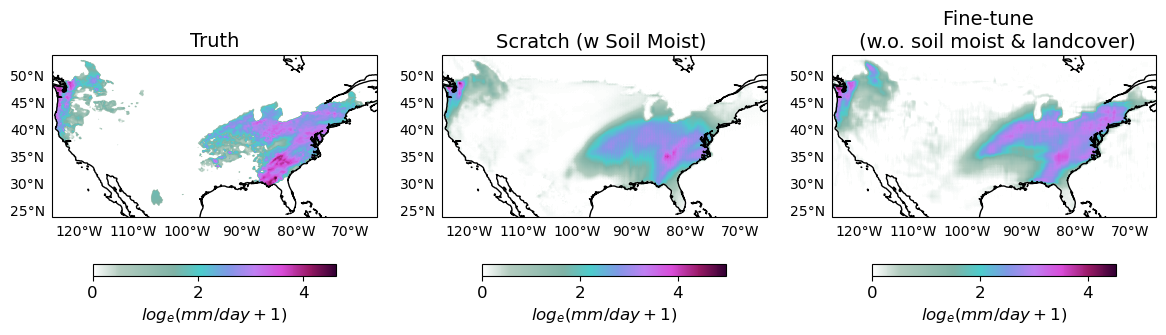

In [52]:
ncols=3
nrows=1
fts=14
cbar_tick_size=12
cbar_xlabel=12
lons[lons>180] -= 360
lonmin, lonmax = np.min(lons), np.max(lons)
latmin, latmax = np.min(lats), np.max(lats)

fig, axes = plt.subplots(nrows,ncols,figsize=(9.5*3/2, 4*nrows),
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})
axes = axes.flatten()

# Define extracted colors (normalized RGB values)
colors = [
    (1.0, 1.0, 1.0), (0.7, 0.8, 0.75), (0.6, 0.75, 0.7),
    (0.5, 0.7, 0.65), (0.3, 0.8, 0.8), (0.5, 0.6, 0.9), (0.75, 0.5, 0.95),
    (0.85, 0.3, 0.85), (0.6, 0.1, 0.4), (0.2, 0.0, 0.2)
]

# Create custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_precipitation", colors)

for ax , tname, V, cbar_title_name in zip(
        axes, ['Truth', 'Scratch (w Soil Moist) ', 'Fine-tune  \n (w.o. soil moist & landcover)'],
        [Truths['prcp-mse-3129425'][0],
         Preds['prcp-mse-3129425'][0], 
         Preds['prcp-imagegradient-3128692'][0]],
        [r'$log_e(mm/day+1)$', r'$log_e(mm/day+1)$',  r'$log_e(mm/day+1)$']
    ):
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
    im = ax.imshow(V, cmap = custom_cmap, transform=ccrs.PlateCarree(), 
              extent=[lonmin, lonmax, latmin, latmax], vmin=0,
              )
    ax.set_title(tname, fontsize=fts)
    ax.coastlines()  #Currently can be one of “110m”, “50m”, and “10m”.
    
    # grid format
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                        draw_labels=True,)
    gl.xlines = False
    gl.ylines = False
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', shrink=.75)
    cbar.ax.set_xlabel(cbar_title_name, fontsize=cbar_xlabel)
    cbar.ax.tick_params(labelsize=cbar_tick_size)

figdir="./figs"
os.makedirs(figdir, exist_ok=True)
plt.savefig("./prcp_truth-predict_img0_2021_fine-tune-scratch-img_15-3.75arcmin_march7.png", dpi=140)
plt.show()

#### Dan's request

##### v.1

In [ ]:
era5_input = np.load("10arcmin_2021era5tp.npy")

In [ ]:
daymet_input = np.load("10arcmin_2021daymet5prcp.npy")

In [ ]:
era5_input.shape, daymet_input.shape

In [ ]:
it=0

In [ ]:
plt.imshow(np.log1p(era5_input[it, 0, ::-1]*1000))
plt.colorbar()

##### v.2

In [53]:
os.getcwd()

'/Users/ttt/Documents/projects/super-resolution'

In [54]:
era5_input = np.load("./era5_total_precip_2021001.npy")

In [55]:
mask_era5 = np.load("./era5_land_sea_mask_2021.npy")

In [56]:
era5_input.shape, mask_era5.shape

((120, 240), (120, 240))

In [62]:
masked_era5_input = mask_era5[::-1] * era5_input[::-1]

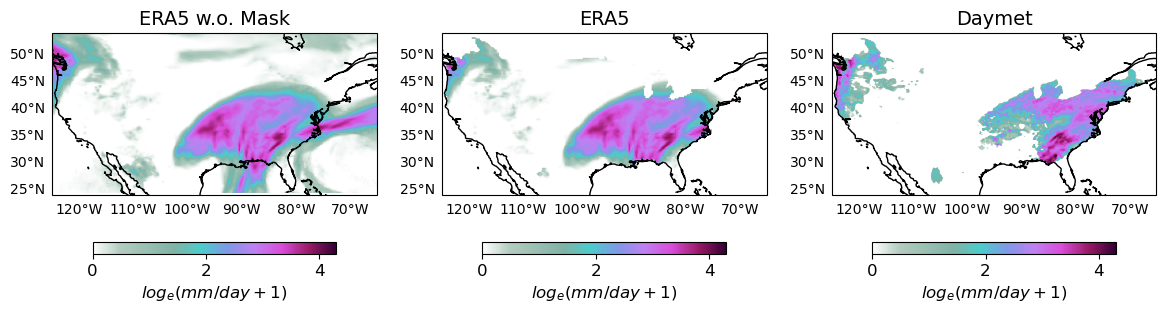

In [67]:
it = 0
vmax = 4.3
ncols=3
nrows=1
fts=14
cbar_tick_size=12
cbar_xlabel=12
lons[lons>180] -= 360
lonmin, lonmax = np.min(lons), np.max(lons)
latmin, latmax = np.min(lats), np.max(lats)

fig, axes = plt.subplots(nrows,ncols,figsize=(9.5*ncols/2, 4*nrows),
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})
axes = axes.flatten()

# Define extracted colors (normalized RGB values)
colors = [
    (1.0, 1.0, 1.0), (0.7, 0.8, 0.75), (0.6, 0.75, 0.7),
    (0.5, 0.7, 0.65), (0.3, 0.8, 0.8), (0.5, 0.6, 0.9), (0.75, 0.5, 0.95),
    (0.85, 0.3, 0.85), (0.6, 0.1, 0.4), (0.2, 0.0, 0.2)
]

# Create custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_precipitation", colors)

for ax , tname, V, cbar_title_name in zip(
        axes, ['ERA5 w.o. Mask', 'ERA5', 'Daymet'],
        [era5_input[::-1], 
         masked_era5_input,
         Truths['prcp-mse-3129425'][0]],
        #[era5_input[it, 0, ::-1] , daymet_input[it, 0, ::-1]],
        [r'$log_e(mm/day+1)$', r'$log_e(mm/day+1)$', r'$log_e(mm/day+1)$']
    ):
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
    if 'ERA5' in tname:
        img = np.log1p(V*1000)
    else:
        img = V
    im = ax.imshow(img, cmap = custom_cmap, transform=ccrs.PlateCarree(), 
              extent=[lonmin, lonmax, latmin, latmax], vmin=0, vmax=vmax
              )
    ax.set_title(tname, fontsize=fts)
    ax.coastlines()  #Currently can be one of “110m”, “50m”, and “10m”.
    
    # grid format
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                        draw_labels=True,)
    gl.xlines = False
    gl.ylines = False
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', shrink=.75)
    cbar.ax.set_xlabel(cbar_title_name, fontsize=cbar_xlabel)
    cbar.ax.tick_params(labelsize=cbar_tick_size)

figdir="./figs"
os.makedirs(figdir, exist_ok=True)
plt.savefig("./2021Jan1st_15arcmin_precip_ERA5vsDaymet.png", dpi=140)
plt.show()

##### Mar 13. mse scratch

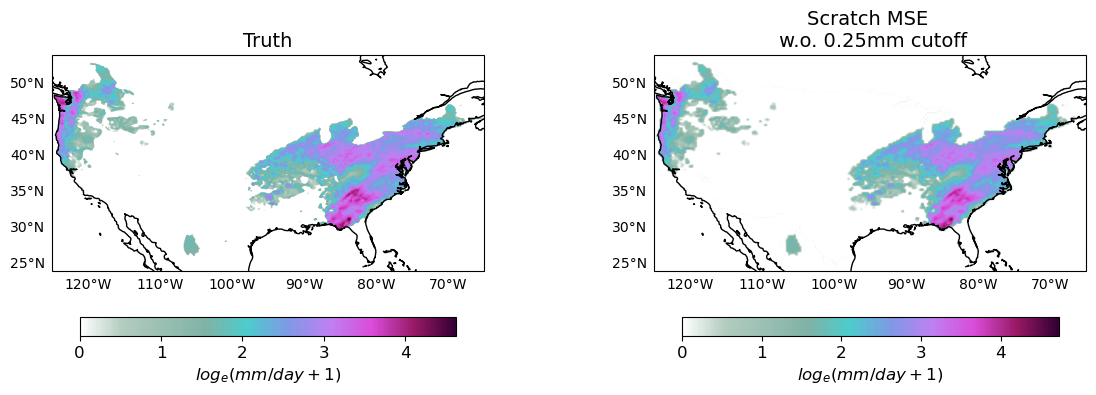

In [27]:
expname=3190616
ncols=2
nrows=1
fts=14
cbar_tick_size=12
cbar_xlabel=12
lons[lons>180] -= 360
lonmin, lonmax = np.min(lons), np.max(lons)
latmin, latmax = np.min(lats), np.max(lats)

fig, axes = plt.subplots(nrows,ncols,figsize=(9.5*3/2, 4*nrows),
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})
axes = axes.flatten()

# Define extracted colors (normalized RGB values)
colors = [
    (1.0, 1.0, 1.0), (0.7, 0.8, 0.75), (0.6, 0.75, 0.7),
    (0.5, 0.7, 0.65), (0.3, 0.8, 0.8), (0.5, 0.6, 0.9), (0.75, 0.5, 0.95),
    (0.85, 0.3, 0.85), (0.6, 0.1, 0.4), (0.2, 0.0, 0.2)
]

# Create custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_precipitation", colors)

for ax , tname, V, cbar_title_name in zip(
        axes, ['Truth', 'Scratch MSE \n w.o. 0.25mm cutoff'],
        [Truths['prcp-mse-3190616'][0], 
         Preds['prcp-mse-3190616'][0], ],
        [r'$log_e(mm/day+1)$', r'$log_e(mm/day+1)$', r'$log_e(mm/day+1)$']
    ):
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
    im = ax.imshow(V, cmap = custom_cmap, transform=ccrs.PlateCarree(), 
              extent=[lonmin, lonmax, latmin, latmax], vmin=0,
              )
    ax.set_title(tname, fontsize=fts)
    ax.coastlines()  #Currently can be one of “110m”, “50m”, and “10m”.
    
    # grid format
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                        draw_labels=True,)
    gl.xlines = False
    gl.ylines = False
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', shrink=.75)
    cbar.ax.set_xlabel(cbar_title_name, fontsize=cbar_xlabel)
    cbar.ax.tick_params(labelsize=cbar_tick_size)

figdir="./figs"
os.makedirs(figdir, exist_ok=True)
plt.savefig(f"./prcp_truth-fine_tune-predict_img0_2021_mse-img_15-3.75arcmin_{expname}.png", dpi=140)
plt.show()

##### Mar 19th 2025

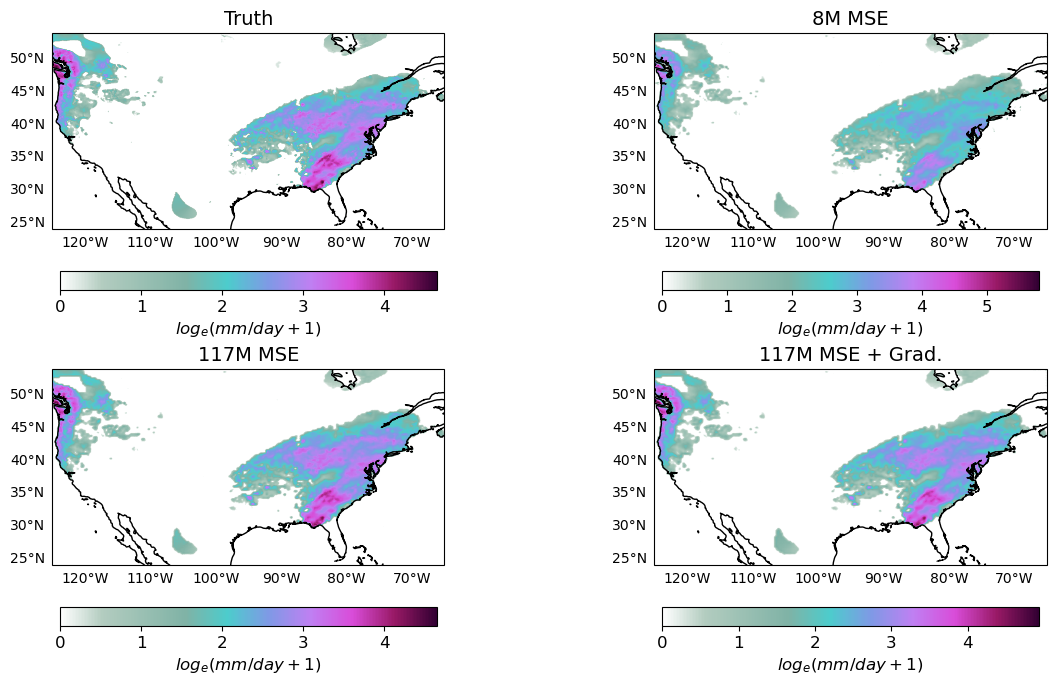

In [124]:
idx = 0
ncols=2
nrows=2
fts=14
cbar_tick_size=12
cbar_xlabel=12
lons[lons>180] -= 360
lonmin, lonmax = np.min(lons), np.max(lons)
latmin, latmax = np.min(lats), np.max(lats)

fig, axes = plt.subplots(nrows,ncols,figsize=(9.5*3/2, 4*nrows),
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})
axes = axes.flatten()

# Define extracted colors (normalized RGB values)
colors = [
    (1.0, 1.0, 1.0), (0.7, 0.8, 0.75), (0.6, 0.75, 0.7),
    (0.5, 0.7, 0.65), (0.3, 0.8, 0.8), (0.5, 0.6, 0.9), (0.75, 0.5, 0.95),
    (0.85, 0.3, 0.85), (0.6, 0.1, 0.4), (0.2, 0.0, 0.2)
]

# Create custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_precipitation", colors)

# 
for ax , tname, V, cbar_title_name in zip(
        axes, ['Truth', '8M MSE', '117M MSE', '117M MSE + Grad.' ],
        [Truths['total_precipitation_24hr-mse-3215715'][idx],
         Preds['total_precipitation_24hr-mse-3215715'][idx], 
         Preds['total_precipitation_24hr-mse-3215780'][idx], 
         Preds['total_precipitation_24hr-imagegradient-3222161'][idx],  
         ],
        [r'$log_e(mm/day+1)$', r'$log_e(mm/day+1)$', r'$log_e(mm/day+1)$',r'$log_e(mm/day+1)$']
    ):
    ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
    im = ax.imshow(V, cmap = custom_cmap, transform=ccrs.PlateCarree(), 
              extent=[lonmin, lonmax, latmin, latmax], vmin=0,
              )
    ax.set_title(tname, fontsize=fts)
    ax.coastlines()  #Currently can be one of “110m”, “50m”, and “10m”.
    
    # grid format
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                        draw_labels=True,)
    gl.xlines = False
    gl.ylines = False
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    cbar = plt.colorbar(im, ax=ax, orientation='horizontal', shrink=.75)
    cbar.ax.set_xlabel(cbar_title_name, fontsize=cbar_xlabel)
    cbar.ax.tick_params(labelsize=cbar_tick_size)

figdir="./figs"
os.makedirs(figdir, exist_ok=True)
plt.savefig(f"./prcp_truth-fine_tune-8m-vs117m--predict_img0_2021_mse-img_15-3.75arcmin_2021{str(idx).zfill(3)}.png", dpi=140)
plt.show()

### Local metrics
- California
- Winter months of west coast

#### Winter west coast USA: all lats and west of -100 lon deg

In [46]:
lons[lons < -100].shape, lons.shape

((400,), (960,))

In [86]:
lon_index0 = np.arange(lons[lons < -100].shape[0])

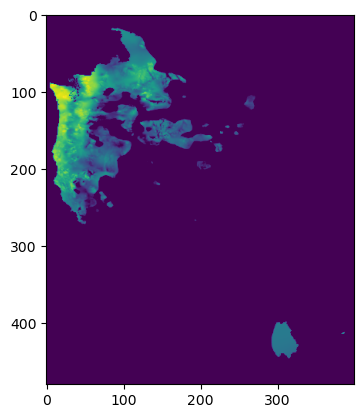

In [ ]:
plt.imshow(Truths['prcp-mse-3076623'][0][:, lon_index0])

In [81]:
lon_index = np.arange(lons[lons < -114].shape[0])

In [65]:
lats[lats < 42]

array([24.    , 24.0625, 24.125 , 24.1875, 24.25  , 24.3125, 24.375 ,
       24.4375, 24.5   , 24.5625, 24.625 , 24.6875, 24.75  , 24.8125,
       24.875 , 24.9375, 25.    , 25.0625, 25.125 , 25.1875, 25.25  ,
       25.3125, 25.375 , 25.4375, 25.5   , 25.5625, 25.625 , 25.6875,
       25.75  , 25.8125, 25.875 , 25.9375, 26.    , 26.0625, 26.125 ,
       26.1875, 26.25  , 26.3125, 26.375 , 26.4375, 26.5   , 26.5625,
       26.625 , 26.6875, 26.75  , 26.8125, 26.875 , 26.9375, 27.    ,
       27.0625, 27.125 , 27.1875, 27.25  , 27.3125, 27.375 , 27.4375,
       27.5   , 27.5625, 27.625 , 27.6875, 27.75  , 27.8125, 27.875 ,
       27.9375, 28.    , 28.0625, 28.125 , 28.1875, 28.25  , 28.3125,
       28.375 , 28.4375, 28.5   , 28.5625, 28.625 , 28.6875, 28.75  ,
       28.8125, 28.875 , 28.9375, 29.    , 29.0625, 29.125 , 29.1875,
       29.25  , 29.3125, 29.375 , 29.4375, 29.5   , 29.5625, 29.625 ,
       29.6875, 29.75  , 29.8125, 29.875 , 29.9375, 30.    , 30.0625,
       30.125 , 30.1

In [79]:
lat_index = np.where(lats < 42)
lat_index[0]

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

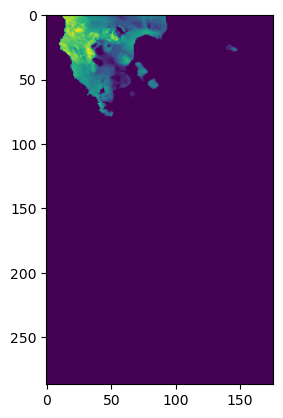

In [80]:
plt.imshow(Truths['prcp-mse-3076623'][0, -287:][..., lon_index])

Get index of winter time (NDJF)

In [48]:
import calendar

ndays = {}
for i in range(1,13,1):
    ndays[calendar.month_name[i]] = calendar.monthrange(2021, i)[1]

In [49]:
ndays

{'January': 31,
 'February': 28,
 'March': 31,
 'April': 30,
 'May': 31,
 'June': 30,
 'July': 31,
 'August': 31,
 'September': 30,
 'October': 31,
 'November': 30,
 'December': 31}

In [51]:
JF = ndays['January'] + ndays['February']
ND = 365 - ndays['November'] - ndays['December']
JF, ND

(59, 304)

In [53]:
time_index = np.hstack([np.arange(JF), np.arange(ND, 365,1)])
time_index

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58, 304, 305, 306, 307, 308, 309,
       310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322,
       323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335,
       336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348,
       349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361,
       362, 363, 364])

#### Calculate local metrics

In [87]:
LocalMetrics = {}
for (k, all_preds), (_, all_truths) in zip(Preds.items(),  Truths.items()):
    
    # slice winter
    winter_preds = all_preds[time_index]
    winter_truths = all_truths[time_index]
    
    # slice area
    preds = winter_preds[..., lon_index0] # all west
    truths = winter_truths[..., lon_index0] 
    
    #preds = winter_preds[-287:][..., lon_index] # california
    #truths = winter_truths[-287:][..., lon_index]
    
    corrs = np.array([])
    wrmses = np.array([])
    s1rmses = np.array([])
    s2rmses = np.array([])
    s3rmses = np.array([])
    ssim_scores = np.array([])
    psnr_scores = np.array([])
    for pred, truth in zip(preds, truths ):
        
        corr = clim_pearsoner(x_sim=pred, x_obs=truth )
        wrmse = lat_weight_rmse(x_sim=pred, x_obs=truth, lat_weights=lat_weights)
        corrs = np.append(corrs, corr) 
        wrmses = np.append(wrmses, wrmse)
        
        # >1, 2, 3 sigma rmses
        s1, s2, s3 = 0.6827, 0.9545, 0.9973
        s1rmse = quantile_rmse(pred, truth, s1)
        s2rmse = quantile_rmse(pred, truth, s2)
        s3rmse = quantile_rmse(pred, truth, s3)
        s1rmses = np.append(s1rmses, s1rmse)
        s2rmses = np.append(s2rmses, s2rmse)
        s3rmses = np.append(s3rmses, s3rmse)
        
        # transformation
        vmin = min(np.nanmin(pred), np.nanmin(truth))
        vmax = max(np.nanmax(pred), np.nanmax(truth))
        pred= normalize(pred, vmax=vmax, vmin=vmin)
        truth= normalize(truth, vmax=vmax, vmin=vmin)  
    
        # calc
        _ssim = ssim(pred, truth)
        _psnr = psnr(pred,truth)
        ssim_scores = np.append(ssim_scores, _ssim)
        psnr_scores = np.append(psnr_scores, _psnr)
        
    # distance
    ralsd = calc_RALSD(truths, preds, nsamples=nsamples)
        
    
    # Add mean
    corr_mean =  np.mean(corrs)
    wrmse_mean= np.mean(wrmses)
    ssim_mean = np.mean(ssim_scores)
    psnr_mean = np.mean(psnr_scores)
    s1rmse_mean = np.mean(s1rmses)
    s2rmse_mean = np.mean(s2rmses)
    s3rmse_mean = np.mean(s3rmses)
    
    # store at dict
    LocalMetrics[k] = {
        'corr': corr_mean,  'rmse': wrmse_mean, 
        "rmse_sigma1": s1rmse_mean,
        "rmse_sigma2": s2rmse_mean,
        "rmse_sigma3": s3rmse_mean,
        'ssim': ssim_mean, 'psnr': psnr_mean,
        "RALSD": ralsd 
    }

480 400
480 400
480 400
480 400
480 400
480 400
480 400
480 400
480 400
480 400
480 400
480 400
480 400
480 400
480 400
480 400


In [88]:
# all west coast
pd.DataFrame(LocalMetrics).T

,corr,rmse,rmse_sigma1,rmse_sigma2,rmse_sigma3,ssim,psnr,RALSD
prcp-mse-3076623,0.748438,0.349394,0.395264,0.980558,1.378313,0.779622,21.699792,2.360736
prcp-mse-3076624,0.748069,0.349693,0.395681,0.991746,1.403375,0.798733,21.666086,2.388553
prcp-mse-3076625,0.729532,0.365174,0.413389,1.040003,1.446413,0.778431,21.241663,2.798328
prcp-mse-3076626,0.731382,0.359948,0.407160,1.023940,1.428215,0.787308,21.424244,2.622691
prcp-imagegradient-3076499,0.751631,0.348807,0.394581,0.990431,1.402632,0.815596,21.477635,2.419522
prcp-imagegradient-3076618,0.752625,0.347400,0.393063,0.988404,1.387744,0.815724,21.591357,2.423728
prcp-imagegradient-3076620,0.735787,0.358578,0.406485,1.020663,1.421706,0.805905,21.317211,2.668033
prcp-imagegradient-3076621,0.732840,0.360527,0.407664,1.031181,1.459636,0.805984,21.280652,2.427557


In [85]:
# california
pd.DataFrame(LocalMetrics).T

,corr,rmse,rmse_sigma1,rmse_sigma2,rmse_sigma3,ssim,psnr,RALSD
prcp-mse-3076623,0.768464,0.406475,0.470169,0.974289,1.364623,0.737689,20.473050,1.841236
prcp-mse-3076624,0.768284,0.408040,0.473074,0.998385,1.397394,0.756192,20.416371,1.961114
prcp-mse-3076625,0.754936,0.425405,0.489908,1.036022,1.420785,0.738274,19.969475,2.305367
prcp-mse-3076626,0.754774,0.419983,0.485893,1.021850,1.403927,0.745190,20.156126,2.116610
prcp-imagegradient-3076499,0.770013,0.408743,0.472467,0.990682,1.390051,0.772458,20.192827,1.872444
prcp-imagegradient-3076618,0.771248,0.405282,0.470640,0.989943,1.369527,0.773999,20.343473,1.928800
prcp-imagegradient-3076620,0.763148,0.416943,0.483657,1.011944,1.393449,0.766798,20.075974,2.131772
prcp-imagegradient-3076621,0.754365,0.422600,0.489113,1.037125,1.439323,0.762411,19.946666,1.873157
